<a href="https://colab.research.google.com/github/EdEnsta/IN104_Edgar_Pereyron_Thea_Levidileon/blob/main/Shap_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Préparation de l'environnement

In [ ]:
!pip install shap

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.applications.imagenet_utils import decode_predictions
import skimage.io 
import skimage.segmentation
import copy
import warnings
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions
from matplotlib.colors import LinearSegmentedColormap
import shap
import keras.backend as K
import json
%matplotlib inline

In [20]:
#fonction permettant de visualiser les shap values d'une image.
# crédit : Dipanjan (DJ) Sarkar, https://djsarkar.medium.com/
def visualize_model_decisions(shap_values, x, labels=None, figsize=(20, 30)):
    
    colors = []
    for l in np.linspace(1, 0, 100):
        colors.append((30./255, 136./255, 229./255,l))
    for l in np.linspace(0, 1, 100):
        colors.append((255./255, 13./255, 87./255,l))
    red_transparent_blue = LinearSegmentedColormap.from_list("red_transparent_blue", colors)

    multi_output = True
    if type(shap_values) != list:
        multi_output = False
        shap_values = [shap_values]

    # make sure labels
    if labels is not None:
        assert labels.shape[0] == shap_values[0].shape[0], "Labels must have same row count as shap_values arrays!"
        if multi_output:
            assert labels.shape[1] == len(shap_values), "Labels must have a column for each output in shap_values!"
        else:
            assert len(labels.shape) == 1, "Labels must be a vector for single output shap_values."

    # plot our explanations
    fig_size = figsize
    fig, axes = plt.subplots(nrows=x.shape[0], ncols=len(shap_values) + 1, figsize=fig_size)
    if len(axes.shape) == 1:
        axes = axes.reshape(1,axes.size)
    for row in range(x.shape[0]):
        x_curr = x[row].copy()

        # make sure
        if len(x_curr.shape) == 3 and x_curr.shape[2] == 1:
            x_curr = x_curr.reshape(x_curr.shape[:2])
        if x_curr.max() > 1:
            x_curr /= 255.
        
        axes[row,0].imshow(x_curr)
        axes[row,0].axis('off')
        
        # get a grayscale version of the image
        if len(x_curr.shape) == 3 and x_curr.shape[2] == 3:
            x_curr_gray = (0.2989 * x_curr[:,:,0] + 0.5870 * x_curr[:,:,1] + 0.1140 * x_curr[:,:,2]) # rgb to gray
        else:
            x_curr_gray = x_curr

        if len(shap_values[0][row].shape) == 2:
            abs_vals = np.stack([np.abs(shap_values[i]) for i in range(len(shap_values))], 0).flatten()
        else:
            abs_vals = np.stack([np.abs(shap_values[i].sum(-1)) for i in range(len(shap_values))], 0).flatten()
        max_val = np.nanpercentile(abs_vals, 99.9)
        for i in range(len(shap_values)):
            if labels is not None:
                axes[row,i+1].set_title(labels[row,i])
            sv = shap_values[i][row] if len(shap_values[i][row].shape) == 2 else shap_values[i][row].sum(-1)
            axes[row,i+1].imshow(x_curr_gray, cmap=plt.get_cmap('gray'), alpha=0.15, extent=(-1, sv.shape[0], sv.shape[1], -1))
            im = axes[row,i+1].imshow(sv, cmap=red_transparent_blue, vmin=-max_val, vmax=max_val)
            axes[row,i+1].axis('off')
        
    cb = fig.colorbar(im, ax=np.ravel(axes).tolist(), label="SHAP value", orientation="horizontal", aspect=fig_size[0]/0.2)
    cb.outline.set_visible(False)

# Importation du modèle et prédictions

Comme dans le cas de Lime nous utilisons un modèle pré entraîné pour réaliser la prédictions de nos images. Il s'agit d'un autre modèle du style de V3Inception.

-----------------------------------------------------------------------

As in the case of Lime we use a pre-trained model to perform the prediction of our images. This is another V3Inception style model.

In [21]:
#Importation du modèle
model = VGG16(weights='imagenet',include_top=True)

Pour shap une base de donnée d'images est directement disponibles sur internet, nous allons donc l'utiliser et choisir une image au hasard dans cette base. 

------------------------------------------------------------------------

For shap a database of images is directly available on the internet, so we will use it and choose an image at random in this database. 

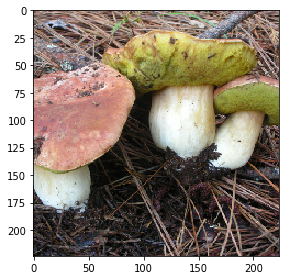

In [22]:
X, y = shap.datasets.imagenet50()  #base de données d'images
picture = np.array([X[45]])   #image choisie au hasard
skimage.io.imshow(picture[0]/255)


In [23]:
# Récupération du label de l'image
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
fname = shap.datasets.cache(url)
with open(fname) as f:
    class_names = json.load(f)

In [24]:
#prédictions du model
preds = model(preprocess_input(picture.copy()),training=True)

#On récupère la prédiction avec la probabilité la plus forte
predicted_labels = [class_names.get(str(pred)) for pred in np.argmax(preds, axis=1)]
print(predicted_labels)


[['n13054560', 'bolete']]


# Explications du modèle

In [25]:
#utilisation de la méthode Shap Gradient Explainer
explainer = shap.GradientExplainer(model,picture)

# #détermination des shaps values
# shap_values = explainer.shap_values(picture)

# #visualisation de l'explication du modèle
# visualize_model_decisions(shap_values=shap_values, x=picture, labels=index_names, figsize=(20, 40))

La détermination des shap values ne fonctionne pas, le code compile mais l'exécution prend énormément de temps, après 40 min la cellule n'avait toujours pas fini de s'exécuter. Normalement en ayant déterminer ces valeurs on aurait été capable de visualiser quelles parties de l'image ont été utiles au réseau de neurones pour sa prédiction, c'est ce que réalisait le code juste après les shap values.

-------------------------------------------------------------------------------

The determination of the shap values does not work, the code compiles but the execution takes a long time, after 40 min the cell had still not finished to execute. Normally by having determined these values we would have been able to visualize which parts of the image were useful to the neural network for its prediction, this is what the code did just after the shap values.